In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms


In [ ]:
print(torch.cuda.device_count())

0


In [2]:
# Train-test-val split
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 1000

# Image transformations of Torchvision will convert to the images to tensor and normalise with mean and standard deviation
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

dataset_train_to_split = torchvision.datasets.MNIST('Data/data/mnist', download=True, train=True, transform=transformer)
dataset_train, dataset_val = torch.utils.data.random_split(dataset_train_to_split, [50000, 10000])

dataset_test = torchvision.datasets.MNIST('Data/data/mnist', download=True, train=False, transform=transformer)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=False, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=False, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, drop_last=False, shuffle=True)


Extracting Data/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to Data/data/mnist/MNIST/raw


Extracting Data/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to Data/data/mnist/MNIST/raw


Extracting Data/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/data/mnist/MNIST/raw


Extracting Data/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
class Cnn(nn.Module):
    """Cnn inherits from Pytorch nn.Module base class.

    Attributes:
        conv1: First convolutional layer of the network.
        conv2: Second convolutional layer of the network.
        fc1: First hidden layer of the network.
        fc2: Output layer of the network.
        drop_out: Used to apply drop out to neurons.
    
    """
    def __init__(self):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2) #kernel_size = 5 & stride = 1(default) & padding will keep output image size the same
        self.conv2 = nn.Conv2d(32, 64, 5 ,1, padding=2)
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7*7*64, 1000, True)
        self.fc2 = nn.Linear(1000, 10, True)
    
    def forward(self, x):
        """Forward propogation.

        Args:
            x: Input of the network, dataloader in this case.

        Returns:
            Output of the network for classification.

        """
        o = F.relu(self.conv1(x))
        o = F.max_pool2d(input=o, kernel_size=2, stride=2)
        o = F.relu(self.conv2(o))
        o = F.max_pool2d(input=o, kernel_size=2, stride=2)
        o = o.reshape(o.shape[0], -1) #Flatten
        o = self.drop_out(o)
        o = F.relu(self.fc1(o))
        o = self.fc2(o)
        return o

    def evaluate(self, dataloader):
        """Evaluates accuracy of the network for the given data.

        Args:
            dataloader: Dataloader for the dataset to be evaluated.

        Returns:
            Accuracy of the network for the given dataset.

        """
        self.eval() # disables drop-out for increased accuracy
        with torch.no_grad(): # disables autograd as derivatives not required. 
            correct_preds = 0
            total_samples = 0
            for X, y_test in dataloader:
                if torch.cuda.is_available():
                    X, y_test= X.cuda(), y_test.cuda() 
                output = self.forward(X)
                y_pred = torch.argmax(output, 1)
                correct_preds += (y_pred == y_test).sum().item()
                total_samples += y_test.shape[0]
            accuracy = (correct_preds / total_samples) * 100
            return accuracy

In [14]:
model = Cnn()
model.to(device)

loss_function = nn.CrossEntropyLoss()
#optimiser = optim.SGD(model.parameters(), lr=0.01)
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [16]:
Epochs = 50
early_stop_patience = 10
max_val_accuracy = 0
early_stop_counter = 0
total_steps = len(dataloader_train)
for epoch in range(Epochs):
    total_samples = 0
    correct_preds = 0
    for step, (X, y) in enumerate(dataloader_train):
        if torch.cuda.is_available():
            X, y= X.cuda(), y.cuda()
        optimiser.zero_grad()
        output = model(X)
        loss = loss_function(output, y)
        loss.backward()
        optimiser.step()
        total_samples += y.shape[0]
        y_pred = torch.argmax(output, 1)
        correct_preds += (y_pred == y).sum().item()
        #print(f"Epoch: {epoch} Step:{step+1}/{total_steps} Loss:{loss_rounded}")
    train_accuracy = (correct_preds / total_samples) * 100
    loss_rounded = round(loss.item(), 2)
    val_accuracy = model.evaluate(dataloader_val)
    print(f"Epoch {epoch+1} loss:{loss_rounded} train_accuracy: {train_accuracy} val_accuracy:{val_accuracy}")
    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter == early_stop_patience:
            print(f"Stopping: Accuracy not increased for the last {early_stop_counter} epochs")
            print(f"Training accuracy: {train_accuracy}")
            break

Epoch 1 loss:0.11 train_accuracy: 93.926 val_accuracy:97.19
Epoch 2 loss:0.07 train_accuracy: 97.98599999999999 val_accuracy:98.05
Epoch 3 loss:0.05 train_accuracy: 98.69200000000001 val_accuracy:98.46000000000001
Epoch 4 loss:0.03 train_accuracy: 98.976 val_accuracy:98.6
Epoch 5 loss:0.02 train_accuracy: 99.236 val_accuracy:98.92999999999999
Epoch 6 loss:0.03 train_accuracy: 99.384 val_accuracy:98.82
Epoch 7 loss:0.02 train_accuracy: 99.566 val_accuracy:98.86
Epoch 8 loss:0.01 train_accuracy: 99.64 val_accuracy:98.79
Epoch 9 loss:0.03 train_accuracy: 99.71600000000001 val_accuracy:98.98
Epoch 10 loss:0.01 train_accuracy: 99.724 val_accuracy:98.9
Epoch 11 loss:0.0 train_accuracy: 99.806 val_accuracy:98.99
Epoch 12 loss:0.0 train_accuracy: 99.8 val_accuracy:98.92999999999999
Epoch 13 loss:0.01 train_accuracy: 99.92 val_accuracy:98.98
Epoch 14 loss:0.0 train_accuracy: 99.92 val_accuracy:99.05000000000001
Epoch 15 loss:0.0 train_accuracy: 99.944 val_accuracy:98.97
Epoch 16 loss:0.0 train_

In [17]:
print(f"Final Accuracy on test data: {model.evaluate(dataloader_test)}")

Final Accuracy on test data: 99.21


In [18]:
from sklearn.metrics import confusion_matrix
predictions, labels = [], []

model.eval()
with torch.no_grad():
    for X, y in dataloader_test:
        if torch.cuda.is_available():
            X, y= X.cuda(), y.cuda()
        output = model.forward(X)
        y_pred = torch.argmax(output, 1)
        # convert to numpy arrays
        y_pred = y_pred.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        for i in range(len(y_pred)):
            predictions.append(y_pred[i])
            labels.append(y[i])

cf_matrix = confusion_matrix(labels, predictions)

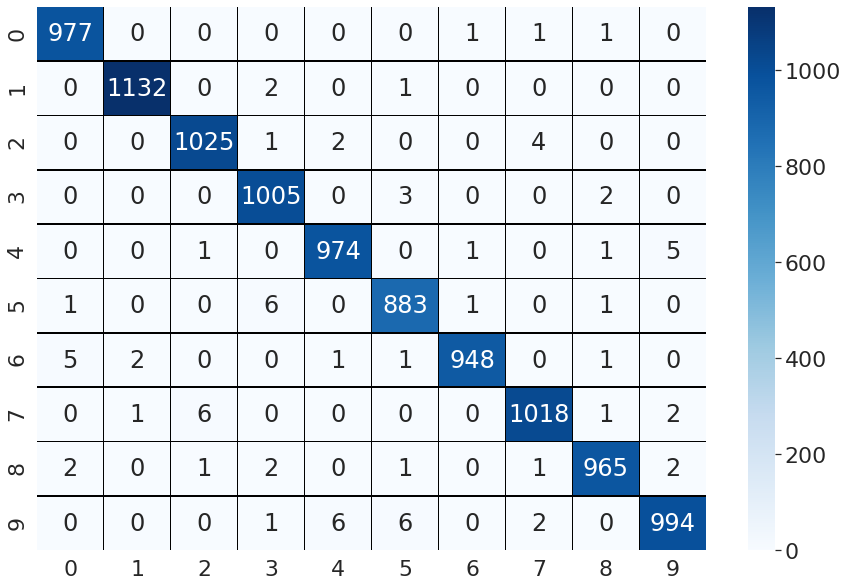

In [19]:
import seaborn as sns
import numpy as np
import seaborn as sns
plt.figure(figsize = (15,10))
sns.set(font_scale=2)
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap="Blues", linewidths=0.5, linecolor='black')